In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
import sys
from math import sqrt
%matplotlib inline
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

### 1. Классификация. Анализ стоит ли давать кредит человеку основываясь на параметрах.

In [2]:
data = pd.read_csv("credit_risk_dataset.csv")

In [3]:
data = data[0:5000]

### 2. Препроцессинг данных

In [4]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  5000 non-null   int64  
 1   person_income               5000 non-null   int64  
 2   person_home_ownership       5000 non-null   object 
 3   person_emp_length           4791 non-null   float64
 4   loan_intent                 5000 non-null   object 
 5   loan_grade                  5000 non-null   object 
 6   loan_amnt                   5000 non-null   int64  
 7   loan_int_rate               4535 non-null   float64
 8   loan_status                 5000 non-null   int64  
 9   loan_percent_income         5000 non-null   float64
 10  cb_person_default_on_file   5000 non-null   object 
 11  cb_person_cred_hist_length  5000 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 468.9+ KB


In [6]:
data.isnull().sum()

person_age                      0
person_income                   0
person_home_ownership           0
person_emp_length             209
loan_intent                     0
loan_grade                      0
loan_amnt                       0
loan_int_rate                 465
loan_status                     0
loan_percent_income             0
cb_person_default_on_file       0
cb_person_cred_hist_length      0
dtype: int64

In [7]:
data["person_emp_length"].fillna(data["person_emp_length"].median(), inplace=True)
data["loan_int_rate"].fillna(data["loan_int_rate"].median(), inplace=True)
data.drop_duplicates(inplace=True)

### 2*. Посмотрим на корреляцию данных.

In [8]:
def find_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]

In [9]:
likely_to_have_outlier = ["person_age","person_income","person_emp_length","cb_person_cred_hist_length"]
for col in likely_to_have_outlier:
    print(find_outliers(data, col).shape)

(4, 12)
(440, 12)
(2, 12)
(0, 12)


In [10]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5*IQR
    upper_range = Q3 + 1.5*IQR
    df[col] = np.where(df[col]>upper_range, upper_range, df[col])
    df[col] = np.where(df[col]<lower_range, lower_range, df[col])
    return df

In [11]:
for col in likely_to_have_outlier:
    remove_outliers(data, col)

In [12]:
data = data.drop(columns=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file'])

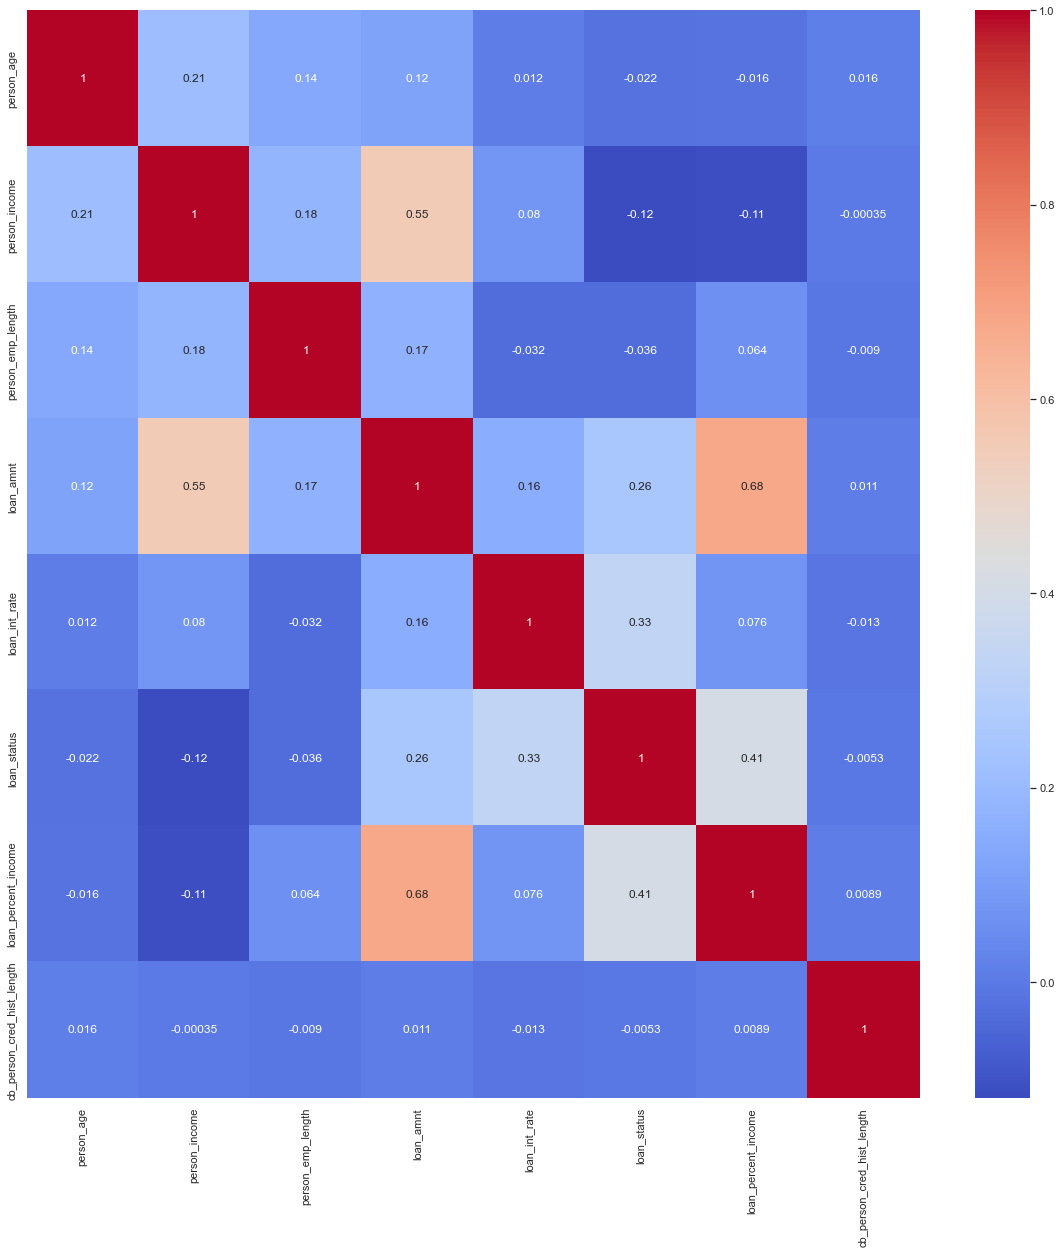

In [13]:
figure = plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
None

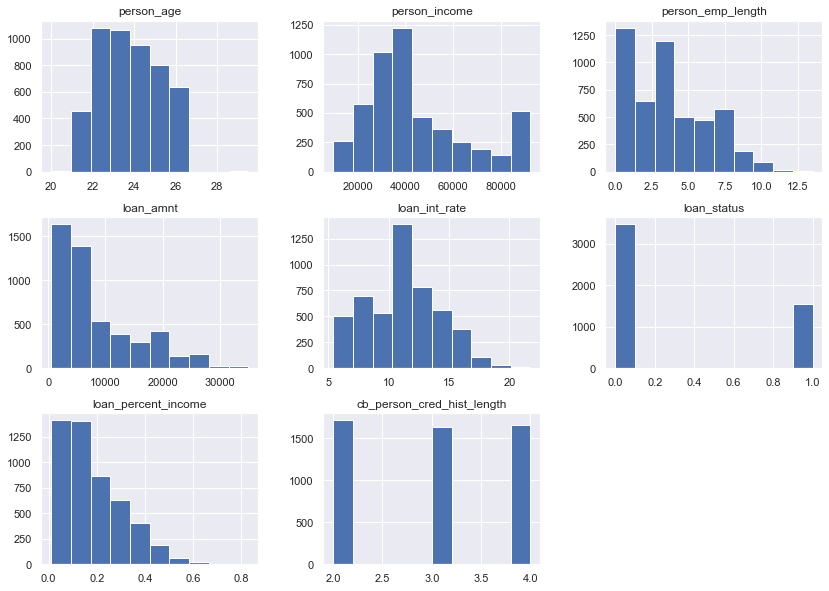

In [14]:
data.hist(column=data.columns, figsize=(14, 10))
None

### 3. Реализация метрики качества. \\ аргументировать выбор метрики качества 

Так как у нас всего два класса, используем оценки качества precision и recall, но нам надо обьеденить их в одну, поэтому используем новое выражение называемое F-мерой, который считается как 
```(1 + betta**2) * (precision * recall) / ((betta**2 * precision) + recall)```

In [15]:
def F(x, y, betta=1):
    TP = sum([x[i] == 1 and y[i] == 1 for i in range(len(x))])
    FP = sum([x[i] == 1 and y[i] == 0 for i in range(len(x))])
    FN = sum([x[i] == 0 and y[i] == 1 for i in range(len(x))])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN + 1)
    return (1 + betta**2) * (precision * recall) / ((betta**2 * precision) + recall)

In [16]:
target_columns = data.columns[5:6]

In [17]:
y = data[target_columns]

In [18]:
data.drop(columns=target_columns ,inplace=True)

In [19]:
X = data[data.columns]

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2)

### Реализация Standart Scaller

In [21]:
def scaller(data):
    data = data.transpose()
    for row in data:
        avg = sum([x for x in row]) / len(row)
        dist = sqrt(sum([(x-avg)**2 for x in row]) / len(row))
        for i in range(len(row)):
            row[i] = (row[i] - avg) / dist
    return data.transpose()

In [22]:
X_scalled = scaller(X.to_numpy())
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_scalled, y, test_size=0.2)
X_train_S.shape, X_test_S.shape, y_train_S.shape, y_test_S.shape

((4000, 7), (1000, 7), (4000, 1), (1000, 1))

### 4. Реализовать и обучить логистическую регрессию или линейную регрессию \\ !!!не разрешается использовать sklearn!!!

In [23]:
class LR:
    def __init__(self, step=10**-2, it_c=100):
        self.step = step
        self.it_c = it_c

    def get_coeff(self, x, y):
        return self.err(x, y.values.ravel())
    
    def err(self, x, y):
        p = [self.predict(i) for i in x]
        return sum(p==y) / len(y)
    
    def reg(self):
        return 0
    
    def fit(self, x, y):
        y = y.to_numpy().ravel()
        np.c_[x, np.ones(len(x))]
        self.w = np.zeros(x.shape[1])
        f, h = [], []
        for i in range(self.it_c):
            z = [sum([x[i][j]*self.w[j] for j in range(len(x[i]))]) for i in range(len(x))]
            res = np.array([1 / (1 + np.exp(-a)) for a in z])
            grad = np.dot(x.T, res - y) / y.size
            self.w -= self.step * grad - self.reg()
            h.append(self.err(x, y))
            f.append(F(self.predict(x), y))
        return h, f
            
    def predict(self, x):
        np.append(x,1)
        return (1 / (1 + np.exp(-np.dot(x, self.w)))).round()
    
    def F_mera(self, x, y):
        f(x,y)

### 4*. Добавить регуляризацию \\ не разрешается использовать sklearn

In [24]:
class LRreg(LR):
    def __init__(self, step=10**-2, it_c=100, L=None, alpha=0.00001):
        self.step = step
        self.it_c = it_c
        self.L = L
        self.alpha = alpha
        
    def reg(self):
        if self.L == 'L1':
            return self.alpha * sum([abs(i) for i in self.w])
        elif self.L == 'L2':
            return self.alpha * sum([i**2 for i in self.w])
        else:
            return 0

### 5. Оценить качество модели на обучающей и тестовой выборках \\ не разрешается использовать sklearn

### Сначала обучим на наших данных

In [25]:
mlg = LR()
hist, f = mlg.fit(X_train, y_train)
print(f"\nmy LogReg: {mlg.get_coeff(X_test, y_test)}")


my LogReg: 0.681


In [26]:
mlgL1 = LRreg(L='L1')
histL1, fL1 = mlgL1.fit(X_train, y_train)
print(f"\nmy LogReg L1: {mlgL1.get_coeff(X_test, y_test)}")


my LogReg L1: 0.548


In [27]:
mlgL2 = LRreg(L='L2')
histL2, fL2 = mlgL2.fit(X_train, y_train)
print(f"\nmy LogReg L2: {mlgL2.get_coeff(X_test, y_test)}")


my LogReg L2: 0.673


### А потом на нормированных

In [28]:
mlg = LR()
hist_S, f_S = mlg.fit(X_train_S, y_train_S)
print(f"\nmy LogReg: {mlg.get_coeff(X_test_S, y_test_S)}")


my LogReg: 0.74


In [29]:
mlgL1 = LRreg(L='L1')
histL1_S, fL1_S = mlgL1.fit(X_train_S, y_train_S)
print(f"\nmy LogReg L1: {mlgL1.get_coeff(X_test_S, y_test_S)}")


my LogReg L1: 0.741


In [30]:
mlgL2 = LRreg(L='L2')
histL2_S, fL2_S = mlgL2.fit(X_train_S, y_train_S)
print(f"\nmy LogReg L2: {mlgL2.get_coeff(X_test_S, y_test_S)}")


my LogReg L2: 0.74


### 5*. Сделать график ошибки модели на обучающей и тестовой выборках 
### 5*. Сделать график точности модели на обучающей и тестовой выборках

#### График точности моделей для всех регулязациях (без нее, L1, L2)

In [31]:
to_be_seen=5

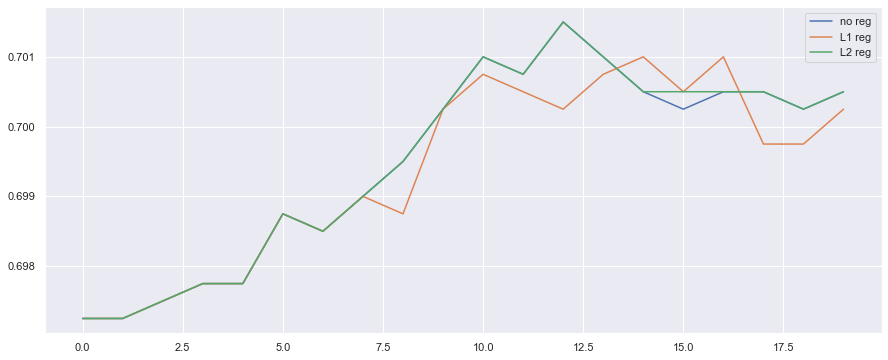

In [32]:
figure = plt.figure(figsize=(15,6))
plt.plot(hist_S[::to_be_seen], label="no reg")
plt.plot(histL1_S[::to_be_seen], label="L1 reg")
plt.plot(histL2_S[::to_be_seen], label="L2 reg")
plt.legend()
plt.show()

#### График метрики моделей для всех регулязациях (без нее, L1, L2) чем больше тем лучше

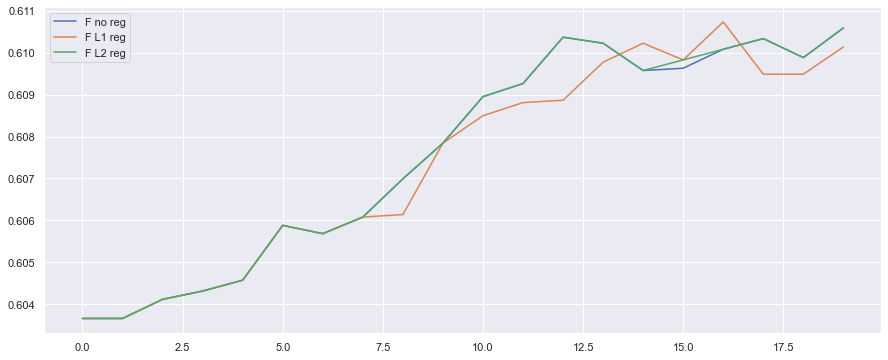

In [33]:
figure = plt.figure(figsize=(15,6))
plt.plot(f_S[::to_be_seen], label="F no reg")
plt.plot(fL1_S[::to_be_seen], label="F L1 reg")
plt.plot(fL2_S[::to_be_seen], label="F L2 reg")
plt.legend()
plt.show()

### 6. Обучить логистическую регрессию или линейную регрессию из sklearn, оценить качество модели на обучающей и тестовой выборках и сравнить со своей моделью

In [34]:
from sklearn.linear_model import LogisticRegression
sklg = LogisticRegression(max_iter=1400)
sklg.fit(X_train, y_train.values.ravel())
print(f"sklearn: {sklg.score(X_test, y_test.values.ravel())}")

sklearn: 0.77


### 6*. Сделать график ошибки модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью
### 6*. Сделать график точности модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью

In [35]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(
    LogisticRegression(max_iter=1400), X_train, y_train.values.ravel(), cv=5)

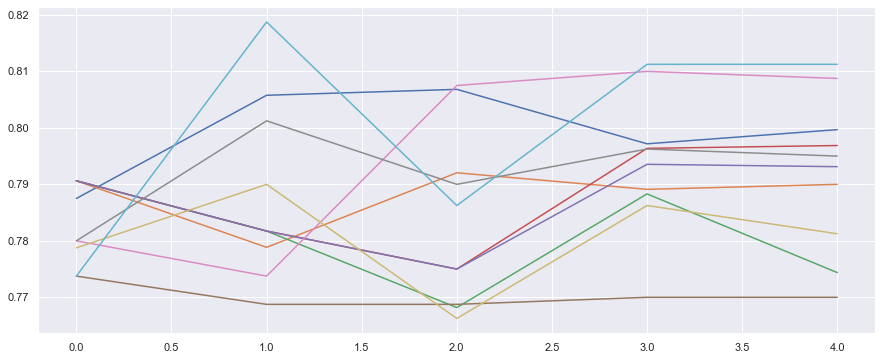

In [36]:
figure = plt.figure(figsize=(15,6))
plt.plot(train_scores)
plt.plot(valid_scores)
plt.show()